# Traffic data analysis

The objective of this notebook is to use data provided by Victor Couture and team to crown "Canada's Worst Commute".

In [106]:
import pandas as pd

# For clustering routes
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import BallTree

# For checking that the clusters look ok
import matplotlib.pyplot as plt
import contextily as ctx
import geopandas as gpd

Filtering for only the columsn I need so the file doesn't get too large.

In [123]:
df = pd.read_parquet('alltrips_canada_2024_2025.parquet')

# Create a datetime column for analysis
df.head(1)

,tripid,mode,citycode,cityname_corrected,time_full_str,traffic_min,dayofweek,tz,trip_dist,lat_dest,lon_dest,lat_orig,lon_orig
0,101497520,0.0,20370,Calgary,20240111 00:56:12,13.3,3,America/Edmonton,9.548,51.060974,-113.951439,51.04414,-114.059586


In [107]:
df = pd.read_parquet('alltrips_canada_2024_2025.parquet', columns=[
    "tripid",
    "mode",
    "citycode",
    "cityname_corrected",
    "time_full_str",
    "traffic_min",
    "dayofweek",
    "tz",
    "trip_dist",
    "lat_dest",
    "lon_dest",
    "lat_orig",
    "lon_orig"
    ])

# Create a datetime column for analysis
df['time_dt'] = pd.to_datetime(df['time_full_str'])

In [108]:
start_date = pd.Timestamp(f"2024-10-01")
end_date = pd.Timestamp(f"2025-09-30")

df = df[(df['time_dt'] <= end_date) & (df['time_dt'] >= start_date)]

df.head()

,tripid,mode,citycode,cityname_corrected,time_full_str,traffic_min,dayofweek,tz,trip_dist,lat_dest,lon_dest,lat_orig,lon_orig,time_dt
3970387,101497520,0.0,20370,Calgary,20241101 09:05:27,15.650000,4,America/Edmonton,9.603,51.060974,-113.951439,51.044140,-114.059586,2024-11-01 09:05:27
3970388,101497521,0.0,20370,Calgary,20241031 00:02:12,13.583333,3,America/Edmonton,9.947,51.044140,-114.059586,51.060974,-113.951439,2024-10-31 00:02:12
3970389,101497521,0.0,20370,Calgary,20241031 08:15:44,21.383333,3,America/Edmonton,9.947,51.044140,-114.059586,51.060974,-113.951439,2024-10-31 08:15:44
3970390,101497540,0.0,20370,Calgary,20241101 14:01:34,23.166667,4,America/Edmonton,15.527,50.949066,-114.085335,51.044357,-114.061646,2024-11-01 14:01:34
3970391,101497551,0.0,20370,Calgary,20241030 20:16:30,13.583333,2,America/Edmonton,10.061,51.044140,-114.063362,51.000732,-114.118637,2024-10-30 20:16:30


Check data start time and end time.

In [109]:
display(df["time_full_str"].min(), df["time_full_str"].max())

'20241029 05:39:11'

'20250929 23:59:46'

How many cities is there data for?

In [110]:
df["cityname_corrected"].unique()

array(['Calgary', 'Edmonton', 'Halifax', 'Hamilton',
       'Kitchener-Cambrigde-Waterloo', 'London', 'Montréal', 'Oshawa',
       'Ottawa', 'Québec', 'Saskatoon', 'St. Catharines-Niagara',
       'Toronto', 'Vancouver', 'Victoria', 'Windsor', 'Winnipeg'],
      dtype=object)

Let's now see how many cities we have in this dataset.

In [111]:
df.loc[:, ["cityname_corrected", "tz"]].drop_duplicates()

,cityname_corrected,tz
3970387,Calgary,America/Edmonton
3971133,Edmonton,America/Edmonton
3971843,Halifax,America/Halifax
3972826,Hamilton,America/Toronto
3973695,Kitchener-Cambrigde-Waterloo,America/Toronto
3974686,London,America/Toronto
3975805,Montréal,America/Toronto
3977878,Oshawa,America/Toronto
3978757,Ottawa,America/Toronto
3980304,Québec,America/Toronto


Now let's do the analysis. I am only using data from the last 6 months of this data: March 2024 through Sept 2024.

For this table, I’ve excluded routes that are less than 10km long, and only included routes with at least 3 data points collected over the past 6 months in both non-rush hour and rush hour (8-10am, 5-7pm) times. I've excluded everything under 10km, because that doesn't really feel like it qualifies as a commute.

In [112]:
# --- Rush Hour Analysis most recent year

df['time_dt'] = pd.to_datetime(df['time_full_str'])
all_data = df[(df['time_dt'].dt.weekday < 5) & (df['trip_dist'] >= 10) & (df['mode'] == 0)].copy()

hour = all_data['time_dt'].dt.hour
is_rush_hour = ((hour >= 8) & (hour < 10)) | ((hour >= 17) & (hour < 19))
all_data['period'] = 'Non-Rush Hour'
all_data.loc[is_rush_hour, 'period'] = 'Rush Hour'

In [115]:
all_data['origin'] = all_data['lat_orig'].astype(str) + ',' + all_data['lon_orig'].astype(str)
all_data['dest'] = all_data['lat_dest'].astype(str) + ',' + all_data['lon_dest'].astype(str)

In [122]:
# --- Rush Hour Analysis most recent year

df['time_dt'] = pd.to_datetime(df['time_full_str'])
all_data = df[(df['time_dt'].dt.weekday < 5) & (df['trip_dist'] >= 10) & (df['mode'] == 0)].copy()

hour = all_data['time_dt'].dt.hour
is_rush_hour = ((hour >= 8) & (hour < 10)) | ((hour >= 17) & (hour < 19))
all_data['period'] = 'Non-Rush Hour'
all_data.loc[is_rush_hour, 'period'] = 'Rush Hour'

grouping_cols = ['tripid', 'cityname_corrected', 'lat_orig', 'lon_orig', 'lat_dest', 'lon_dest', 'trip_dist', 'period']
agg_times = all_data.groupby(grouping_cols)['traffic_min'].agg(['mean', 'count']).reset_index()

comparison_table = agg_times.pivot_table(
    index=[col for col in grouping_cols if col != 'period'],
    columns='period',
    values=['mean', 'count']
).reset_index()

comparison_table.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in comparison_table.columns.values]
comparison_table.rename(columns={
    'mean_Non-Rush Hour': 'mean_non_rush_hour',
    'mean_Rush Hour': 'mean_rush_hour',
    'count_Non-Rush Hour': 'count_non_rush_hour',
    'count_Rush Hour': 'count_rush_hour',
    'tripid_': 'tripid',
    'mode_': 'mode',
    'cityname_corrected_': 'cityname_corrected',
    'lat_orig_': 'lat_orig',
    'lon_orig_': 'lon_orig',
    'lat_dest_': 'lat_dest',
    'lon_dest_': 'lon_dest',
    'trip_dist_': 'trip_dist'
}, inplace=True)

comparison_table.fillna(0, inplace=True)
comparison_table["rush_hour_diff"] = comparison_table['mean_rush_hour'] - comparison_table['mean_non_rush_hour']

for col in ['count_non_rush_hour', 'count_rush_hour']:
    if col in comparison_table.columns:
        comparison_table[col] = comparison_table[col].astype(int)

comparison_table['origin'] = comparison_table['lat_orig'].astype(str) + ',' + comparison_table['lon_orig'].astype(str)
comparison_table['dest'] = comparison_table['lat_dest'].astype(str) + ',' + comparison_table['lon_dest'].astype(str)

final_table = comparison_table.sort_values('rush_hour_diff', ascending=False)
display(final_table[(final_table["count_non_rush_hour"] >= 10) & (final_table["count_rush_hour"] >= 5)][['tripid', 'cityname_corrected', 'origin', 'dest', 'trip_dist', 'mean_non_rush_hour', 'mean_rush_hour', 'count_non_rush_hour', 'count_rush_hour', "rush_hour_diff"]].head(20))


,tripid,cityname_corrected,origin,dest,trip_dist,mean_non_rush_hour,mean_rush_hour,count_non_rush_hour,count_rush_hour,rush_hour_diff
94415,101617601,Toronto,"43.867138,-79.50793","43.65489,-79.385704",43.007,41.869697,62.093333,11,5,20.223636
126724,101636931,Vancouver,"49.299095,-122.79921","49.240627,-123.11095",33.204,38.933333,52.340000,12,5,13.406667
362708,304156470,Vancouver,"49.11764,-122.86204","49.22628,-122.941",19.831,23.525000,36.226667,10,5,12.701667
338728,304101661,Toronto,"43.401985,-79.76679","43.648182,-79.45746",41.142,33.170000,45.530000,10,5,12.360000
80253,101610311,Toronto,"43.821083,-79.34588","43.652157,-79.380554",22.760,29.887500,40.176667,16,5,10.289167
288009,303925231,Montréal,"45.483418,-73.721565","45.472343,-73.61273",10.646,13.046970,23.250000,11,5,10.203030
266676,303804980,Calgary,"50.992954,-113.98474","51.08427,-114.17597",23.654,23.547917,32.416667,16,5,8.868750
388937,45585900,Montréal,"45.49136,-73.742165","45.49203,-73.63268",14.575,16.537500,25.213889,12,6,8.676389
25227,101549911,Montréal,"45.456932,-73.46064","45.50315,-73.59385",15.670,26.630769,35.210000,13,5,8.579231
222066,14180541,Vancouver,"49.257435,-122.91216","49.257435,-123.1161",17.905,23.329762,31.876667,14,5,8.546905


In [ ]:
all_data['origin'] = all_data['lat_orig'].astype(str) + ',' + all_data['lon_orig'].astype(str)
all_data['dest'] = all_data['lat_dest'].astype(str) + ',' + all_data['lon_dest'].astype(str)

Print out maps for each of the top 10 routes.

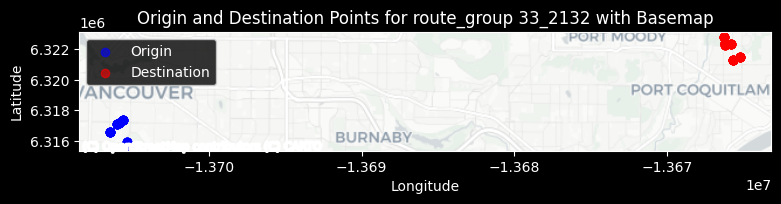

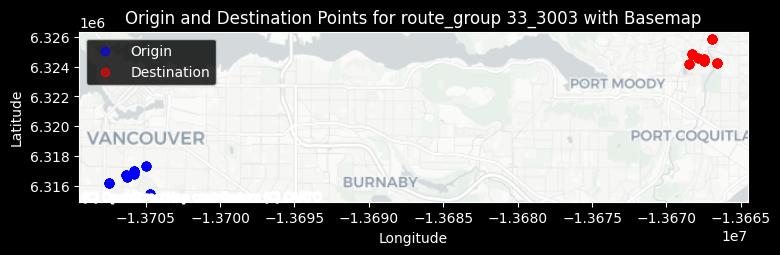

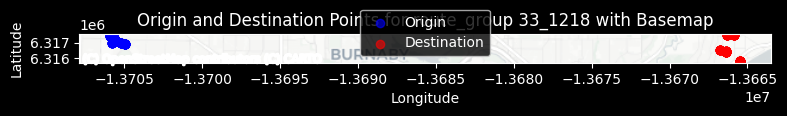

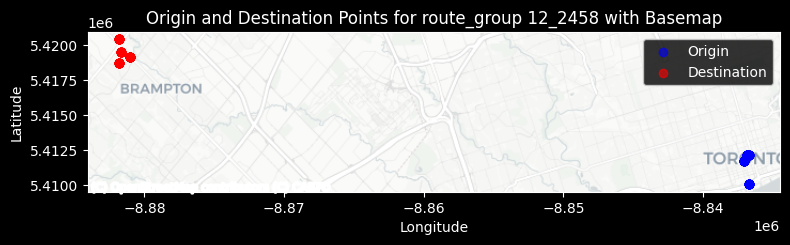

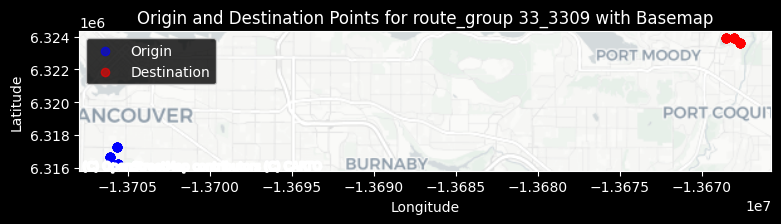

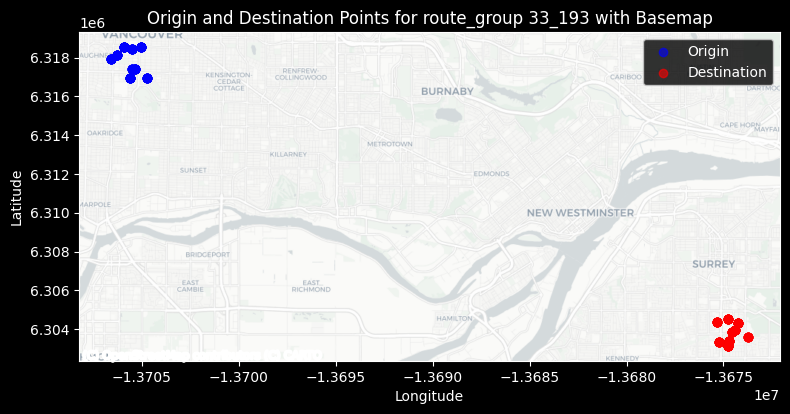

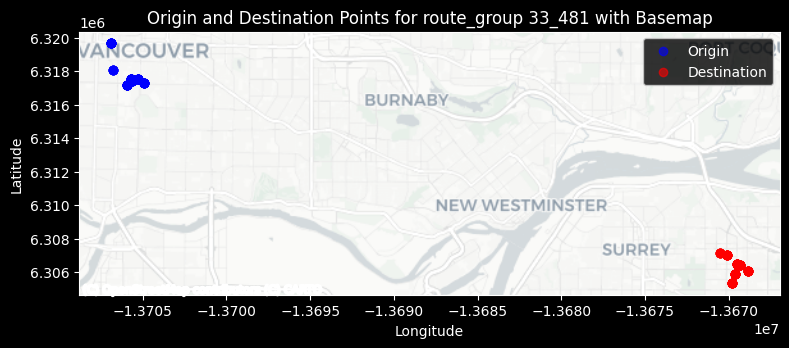

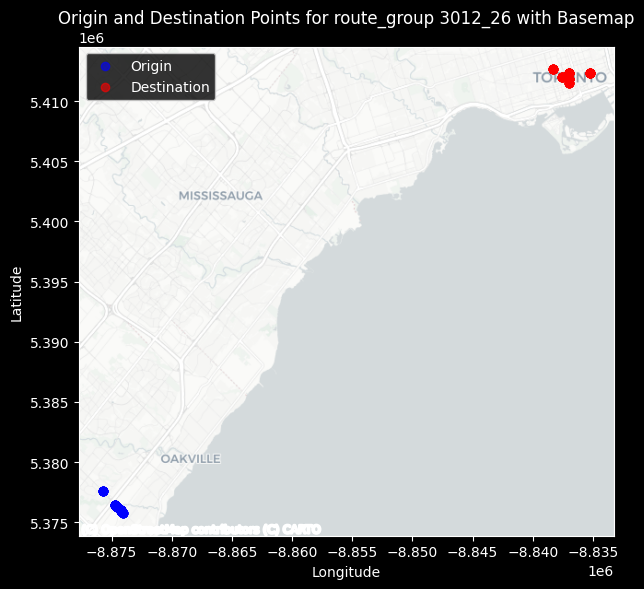

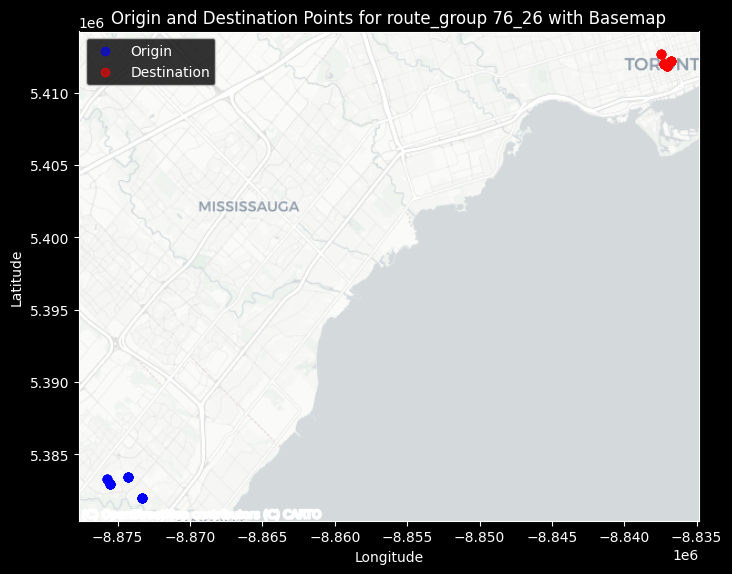

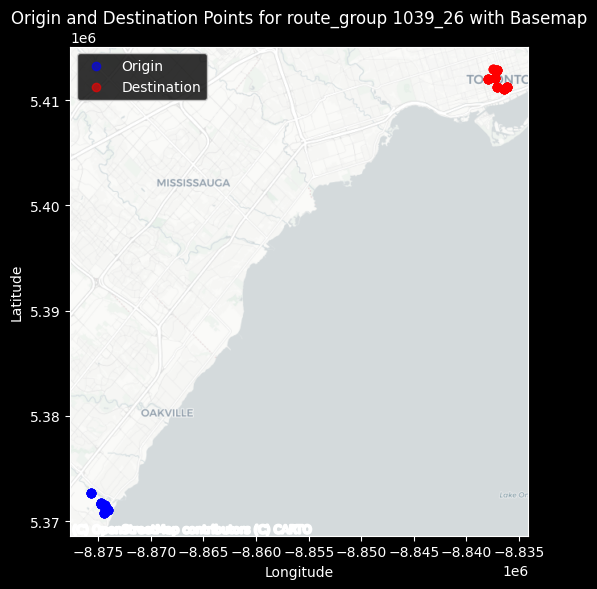

In [ ]:
rgs = display_table.head(10)["route_group"]
for rg in rgs:
    subset = all_data[all_data['route_group'] == rg]

    if subset.empty:
        print(f"No data found for route_group {rg}")
    else:
        # Create GeoDataFrames for origins and destinations
        orig_gdf = gpd.GeoDataFrame(subset, geometry=gpd.points_from_xy(subset['lon_orig'], subset['lat_orig']), crs='EPSG:4326')
        dest_gdf = gpd.GeoDataFrame(subset, geometry=gpd.points_from_xy(subset['lon_dest'], subset['lat_dest']), crs='EPSG:4326')

        # Convert to Web Mercator for contextily
        orig_gdf = orig_gdf.to_crs(epsg=3857)
        dest_gdf = dest_gdf.to_crs(epsg=3857)

        fig, ax = plt.subplots(figsize=(8, 6))
        orig_gdf.plot(ax=ax, marker='o', color='blue', label='Origin', alpha=0.6)
        dest_gdf.plot(ax=ax, marker='o', color='red', label='Destination', alpha=0.6)

        ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_title(f'Origin and Destination Points for route_group {rg} with Basemap')
        ax.legend()
        plt.tight_layout()
        plt.show()
